# GF-KSD: Measure Transport (Figure 4)

In [2]:
import torch
from torch.autograd import grad

import pyro 
import pyro.distributions as pyro_dist
import pyro.distributions.transforms as T
from pyro.nn import AutoRegressiveNN

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from pylab import rcParams
rcParams['figure.figsize'] = 10,6

from steintorch.utils.get_score import get_score
from steintorch.divergence.ksd import KSD, GradientFreeKSD
from steintorch.utils.clip_grad_norm import clip_grad_norm_

## Defining Target Distributions

In [3]:
from toy_distributions import Sinusoidal2D, Banana2D

banana_2D_var = [0.5, 1, 0.2] 
banana2D = Banana2D(banana_2D_var)

sinusoidal_2D_var = [1.2, 1.3, 0.09]
sinusoidal2D = Sinusoidal2D(sinusoidal_2D_var)

#### Plotting Target Distributions:

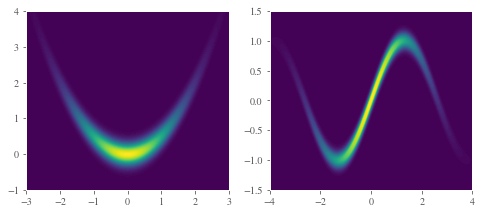

In [5]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(8, 3.3)

n_steps = 600

limx = [-3,3]
limy = [-1,4]

x_banana = torch.linspace(limx[0], limx[1], n_steps)
y_banana = torch.linspace(limy[0], limy[1], n_steps)
xgrid_banana, ygrid_banana = torch.meshgrid(x_banana, y_banana)
xyinput_banana = torch.cat([xgrid_banana.reshape(-1, 1), ygrid_banana.reshape(-1, 1)], dim=1)
axes[0].contourf(xgrid_banana, ygrid_banana, banana2D.log_prob(xyinput_banana).exp().reshape(n_steps, n_steps), levels = 100)

x_sinusoidal = torch.linspace(-4, 4, n_steps)
y_sinusoidal = torch.linspace(-1.5, 1.5, n_steps)
xgrid_sinusoidal, ygrid_sinusoidal = torch.meshgrid(x_sinusoidal, y_sinusoidal)
xyinput_sinusoidal = torch.cat([xgrid_sinusoidal.reshape(-1, 1), ygrid_sinusoidal.reshape(-1, 1)], dim=1)
axes[1].contourf(xgrid_sinusoidal, ygrid_sinusoidal, sinusoidal2D.log_prob(xyinput_sinusoidal).exp().reshape(n_steps, n_steps), levels = 100)

plt.show()

## KSD Variational Inference

In [6]:
_ksd = KSD(None)

### Banana Distribution

In [7]:
torch.manual_seed(0)

base_dist =  pyro_dist.Normal(torch.zeros(2), torch.ones(2))

iaf_ksd_banana = T.AffineAutoregressive(AutoRegressiveNN(2, [20]))
transform_iaf_ksd_banana = pyro_dist.TransformedDistribution(base_dist, [iaf_ksd_banana])

Iteration 0


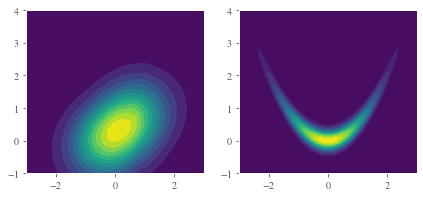

Iteration 2000


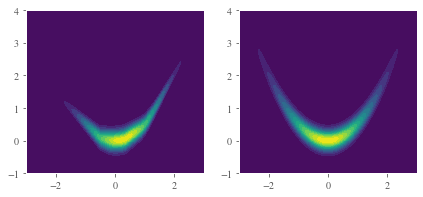

Iteration 4000


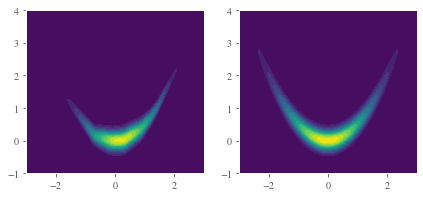

Iteration 6000


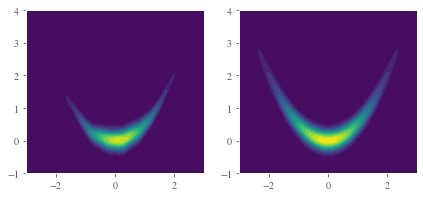

Iteration 8000


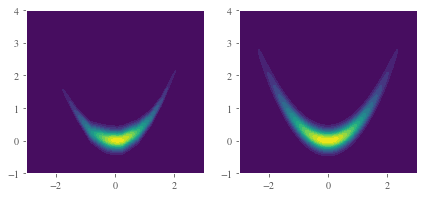

Iteration 10000


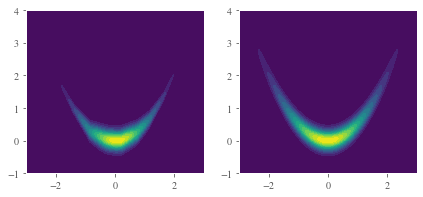

Iteration 12000


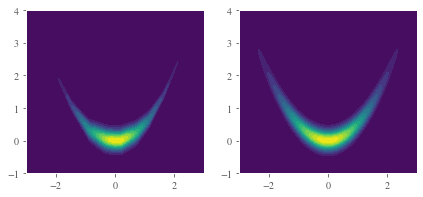

Iteration 14000


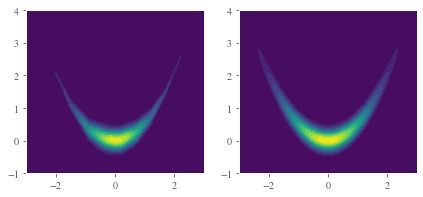

Iteration 16000


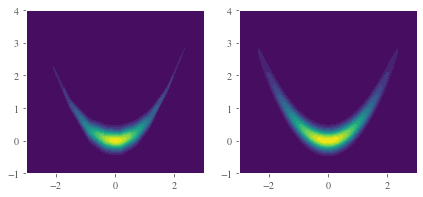

Iteration 18000


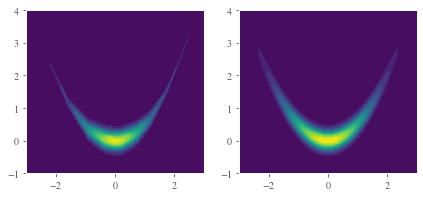

In [8]:
rcParams['figure.figsize'] = 7,3

optimizer = torch.optim.Adam(iaf_ksd_banana.parameters(), lr=1e-3)
batch = 100

for i in range(20000):
    optimizer.zero_grad()

    base_dist_sample = transform_iaf_ksd_banana.base_dist.sample(torch.Size([batch, ]))
    sample = transform_iaf_ksd_banana.transforms[0](base_dist_sample)
    
    loss = _ksd.eval(sample, banana2D.score, preconditioner=torch.Tensor([40]))
    
    if i % 2000 == 0:
        print('Iteration ' + str(i))

        with torch.no_grad():
            zgrid = transform_iaf_ksd_banana.log_prob(xyinput_banana).exp().reshape(n_steps, n_steps)
            bzgrid = banana2D.log_prob(xyinput_banana).exp().reshape(n_steps, n_steps)

            fig, axes = plt.subplots(1, 2)
            axes[0].contourf(xgrid_banana.numpy(), ygrid_banana.numpy(), zgrid.numpy(), levels=15)
            axes[1].contourf(xgrid_banana.numpy(), ygrid_banana.numpy(), bzgrid.numpy(), levels=15)
            plt.show()

    loss.backward()
    optimizer.step()
    transform_iaf_ksd_banana.clear_cache()
    

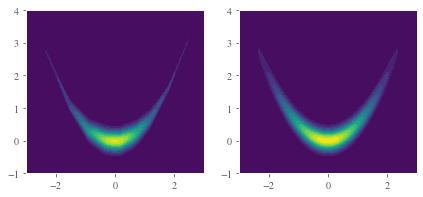

In [9]:
with torch.no_grad():
    zgrid = transform_iaf_ksd_banana.log_prob(xyinput_banana).exp().reshape(n_steps, n_steps)
    bzgrid = banana2D.log_prob(xyinput_banana).exp().reshape(n_steps, n_steps)

fig, axes = plt.subplots(1, 2)

axes[0].contourf(xgrid_banana.numpy(), ygrid_banana.numpy(), zgrid.numpy(), levels=15)
axes[1].contourf(xgrid_banana.numpy(), ygrid_banana.numpy(), bzgrid.numpy(), levels=15)

plt.show()

### Sinusoidal Target

In [10]:
torch.manual_seed(0)

base_dist =  pyro_dist.Normal(torch.zeros(2), torch.ones(2))

iaf_ksd_sinusoidal = T.AffineAutoregressive(AutoRegressiveNN(2, [30]))
transform_iaf_ksd_sinusoidal = pyro_dist.TransformedDistribution(base_dist, [iaf_ksd_sinusoidal])

Iteration 0


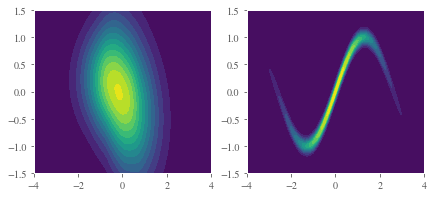

Iteration 2000


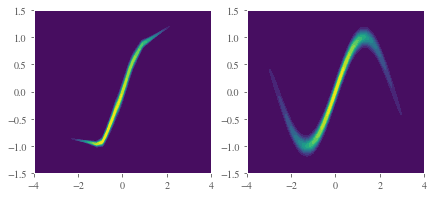

Iteration 4000


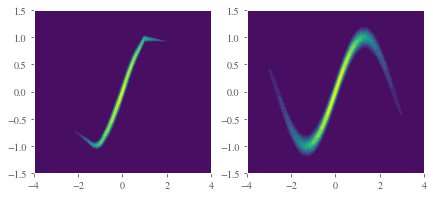

Iteration 6000


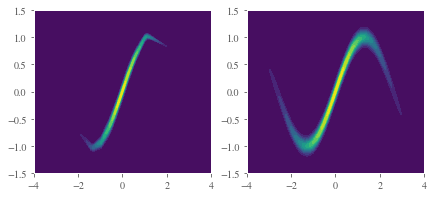

Iteration 8000


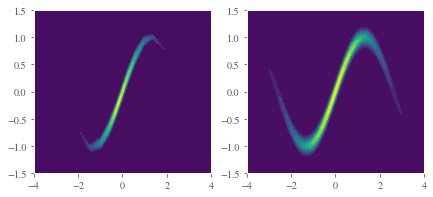

Iteration 10000


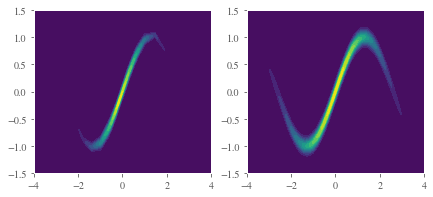

Iteration 12000


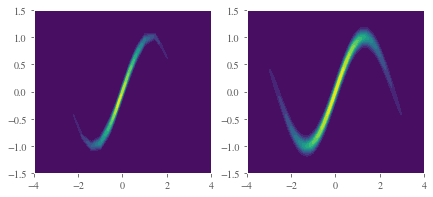

Iteration 14000


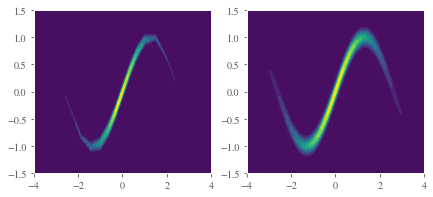

Iteration 16000


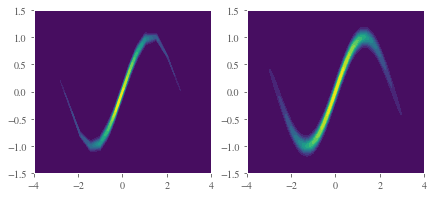

Iteration 18000


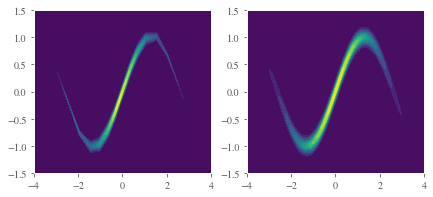

In [11]:
rcParams['figure.figsize'] = 7,3

optimizer = torch.optim.Adam(iaf_ksd_sinusoidal.parameters(), lr=1e-3)
batch = 100

for i in range(20000):
    optimizer.zero_grad()

    base_dist_sample = transform_iaf_ksd_sinusoidal.base_dist.sample(torch.Size([batch, ]))
    sample = transform_iaf_ksd_sinusoidal.transforms[0](base_dist_sample)
    
    loss = _ksd.eval(sample, sinusoidal2D.score, preconditioner=torch.Tensor([25]))
    
    if i % 2000 == 0:
        print('Iteration ' + str(i))
        with torch.no_grad():
            zgrid = transform_iaf_ksd_sinusoidal.log_prob(xyinput_sinusoidal).exp().reshape(n_steps, n_steps)
            bzgrid = sinusoidal2D.log_prob(xyinput_sinusoidal).exp().reshape(n_steps, n_steps)

            fig, axes = plt.subplots(1, 2)

            axes[0].contourf(xgrid_sinusoidal.numpy(), ygrid_sinusoidal.numpy(), zgrid.numpy(), levels=15)
            axes[1].contourf(xgrid_sinusoidal.numpy(), ygrid_sinusoidal.numpy(), bzgrid.numpy(), levels=15)

            plt.show()

    loss.backward()
    optimizer.step()
    transform_iaf_ksd_sinusoidal.clear_cache()
    

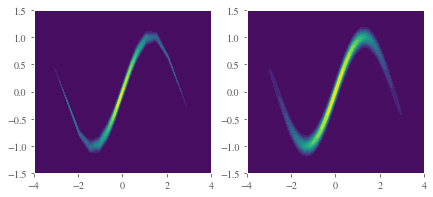

In [12]:
with torch.no_grad():
    zgrid = transform_iaf_ksd_sinusoidal.log_prob(xyinput_sinusoidal).exp().reshape(n_steps, n_steps)
    bzgrid = sinusoidal2D.log_prob(xyinput_sinusoidal).exp().reshape(n_steps, n_steps)

fig, axes = plt.subplots(1, 2)

axes[0].contourf(xgrid_sinusoidal.numpy(), ygrid_sinusoidal.numpy(), zgrid.numpy(), levels=15)
axes[1].contourf(xgrid_sinusoidal.numpy(), ygrid_sinusoidal.numpy(), bzgrid.numpy(), levels=15)

plt.show()

## GF-KSD Variational Inference

In [13]:
gf_KSD = GradientFreeKSD(None)

### Banana Distribution

In [14]:
import copy
torch.manual_seed(0)

base_dist = pyro_dist.Normal(torch.Tensor([0,0]),  torch.ones(2))
tempering_dist = torch.distributions.MultivariateNormal(torch.Tensor([0,0]), 2 * torch.eye(2) )

iaf_gfksd_banana = T.AffineAutoregressive(AutoRegressiveNN(2, [20]))
transform_iaf_gfksd_banana = pyro_dist.TransformedDistribution(base_dist, [iaf_gfksd_banana])

iaf_gfksd_banana_ = copy.deepcopy(iaf_gfksd_banana)
transform_iaf_gfksd_banana_ = pyro_dist.TransformedDistribution(base_dist, [iaf_gfksd_banana_])

iaf_gfksd_banana_0 = copy.deepcopy(iaf_gfksd_banana)
transform_iaf_gfksd_banana_0 = pyro_dist.TransformedDistribution(base_dist, [iaf_gfksd_banana_0])

iaf_gfksd_banana_3000 = copy.deepcopy(iaf_gfksd_banana)
transform_iaf_gfksd_banana_3000 = pyro_dist.TransformedDistribution(base_dist, [iaf_gfksd_banana_3000])

iaf_gfksd_banana_15000 = copy.deepcopy(iaf_gfksd_banana)
transform_iaf_gfksd_banana_15000 = pyro_dist.TransformedDistribution(base_dist, [iaf_gfksd_banana_15000])


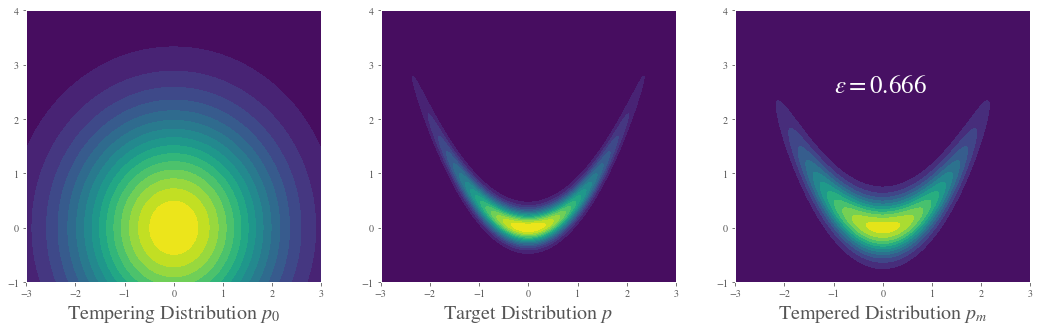

In [15]:
EPS = torch.cat([torch.linspace(1, 0, 15000), torch.zeros(5000)])

nnn = 5000

with torch.no_grad():
    zgrid = tempering_dist.log_prob(xyinput_banana).exp().reshape(n_steps, n_steps)
    bzgrid = banana2D.log_prob(xyinput_banana).exp().reshape(n_steps, n_steps)
    tempgrid = (banana2D.log_prob(xyinput_banana) * (1 - EPS[nnn]) + EPS[nnn] * tempering_dist.log_prob(xyinput_banana)).exp().reshape(n_steps, n_steps)

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18,5)

axes[0].contourf(xgrid_banana.numpy(), ygrid_banana.numpy(), zgrid.numpy(), levels=15)
axes[1].contourf(xgrid_banana.numpy(), ygrid_banana.numpy(), bzgrid.numpy(), levels=15)
axes[2].contourf(xgrid_banana.numpy(), ygrid_banana.numpy(), tempgrid.numpy(), levels=15)

axes[0].set_xlabel('Tempering Distribution $p_0$', fontsize=20)
axes[1].set_xlabel('Target Distribution $p$', fontsize=20)
axes[2].set_xlabel('Tempered Distribution $p_m$', fontsize=20)
axes[2].text(-1,2.5,'$\epsilon=$' + str(float(EPS[nnn]))[0:5], fontsize=25, color='white')

plt.show()

Loss:  tensor(-2.1236, grad_fn=<LogBackward0>)  i:  0


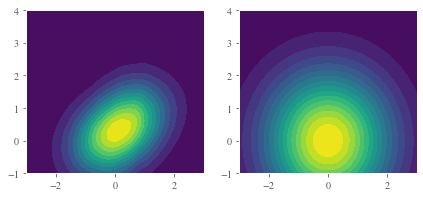

Loss:  tensor(0.0039, grad_fn=<LogBackward0>)  i:  2000


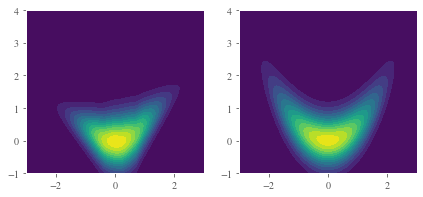

Loss:  tensor(0.4827, grad_fn=<LogBackward0>)  i:  4000


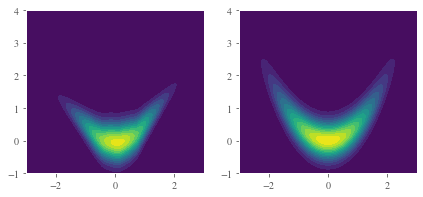

Loss:  tensor(-0.9948, grad_fn=<LogBackward0>)  i:  6000


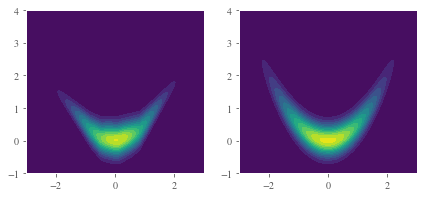

Loss:  tensor(2.1142, grad_fn=<LogBackward0>)  i:  8000


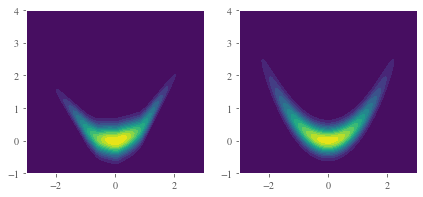

Loss:  tensor(-0.5450, grad_fn=<LogBackward0>)  i:  10000


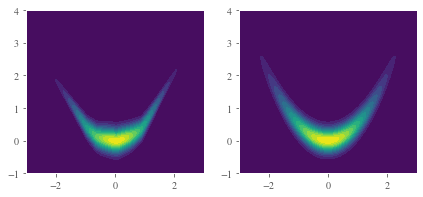

Loss:  tensor(-2.1151, grad_fn=<LogBackward0>)  i:  12000


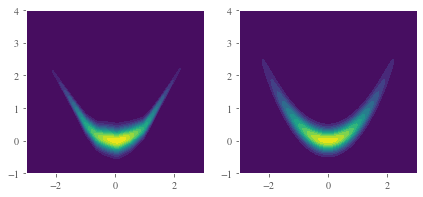

Loss:  tensor(-0.7101, grad_fn=<LogBackward0>)  i:  14000


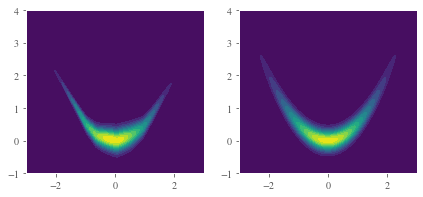

Loss:  tensor(-0.5211, grad_fn=<LogBackward0>)  i:  16000


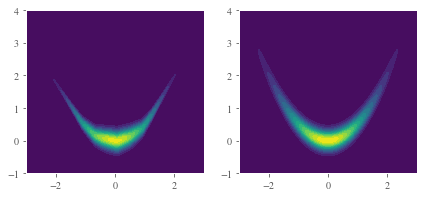

Loss:  tensor(-2.8065, grad_fn=<LogBackward0>)  i:  18000


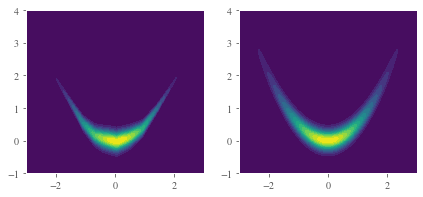

In [16]:
rcParams['figure.figsize'] = 7,3

batch = 100

optimizer = torch.optim.Adam(iaf_gfksd_banana.parameters(), lr=1e-3)

def get_score(x, dist):
    log_probs = dist.log_prob(x)
    grads = grad(log_probs.sum(), x, create_graph=True)[0]
    return grads

TARGET = banana2D
TARGET_SCORE = banana2D.score
CLAMP_P = -25
EPS = torch.cat([torch.linspace(1, 0, 15000), torch.zeros(5000)])
epsilon = 1e-20

for i in range(20000):
    optimizer.zero_grad()

    iaf_gfksd_banana_.load_state_dict(iaf_gfksd_banana.state_dict())
    score_iaf_gfksd_banana_ = lambda x: get_score(x, transform_iaf_gfksd_banana_)

    base_dist_sample = transform_iaf_gfksd_banana.base_dist.sample(torch.Size([batch, ]))
    sample = transform_iaf_gfksd_banana.transforms[0](base_dist_sample)

    target_temp_log_prob = (TARGET.log_prob(sample) * (1 - EPS[i]) + EPS[i] * tempering_dist.log_prob(sample))

    gfksd_u = gf_KSD.eval(sample, target_temp_log_prob, transform_iaf_gfksd_banana_.log_prob, score_iaf_gfksd_banana_, preconditioner=torch.Tensor([40]), clamp_p=CLAMP_P,  V_statistic=False)
    loss =  (torch.abs(gfksd_u + epsilon)).log()


    if i % 2000 == 0:
        print("Loss: ", loss, " i: ", i)
        fig, axes = plt.subplots(1, 2)

        with torch.no_grad():
            zgrid = transform_iaf_gfksd_banana.log_prob(xyinput_banana).exp().reshape(n_steps, n_steps)
            tempgrid = (TARGET.log_prob(xyinput_banana) * (1 - EPS[i]) + EPS[i] * tempering_dist.log_prob(xyinput_banana)).exp().reshape(n_steps, n_steps)

        axes[0].contourf(xgrid_banana.numpy(), ygrid_banana.numpy(), zgrid.numpy(), levels=15)
        axes[1].contourf(xgrid_banana.numpy(), ygrid_banana.numpy(), tempgrid.numpy(), levels=15)
        plt.show()

    if i == 0:
        iaf_gfksd_banana_0.load_state_dict(iaf_gfksd_banana.state_dict())
    if i == 2000:
        iaf_gfksd_banana_3000.load_state_dict(iaf_gfksd_banana.state_dict())
    if i == 10000:
        iaf_gfksd_banana_15000.load_state_dict(iaf_gfksd_banana.state_dict())

    loss.backward()
    clip_grad_norm_(iaf_gfksd_banana.parameters(), max_norm=30, norm_type=2)
    optimizer.step()


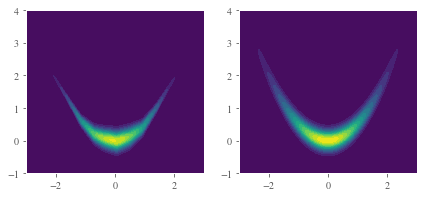

In [17]:
fig, axes = plt.subplots(1, 2)

with torch.no_grad():
    zgrid = transform_iaf_gfksd_banana.log_prob(xyinput_banana).exp().reshape(n_steps, n_steps)
    tempgrid = (TARGET.log_prob(xyinput_banana) * (1 - EPS[i]) + EPS[i] * tempering_dist.log_prob(xyinput_banana)).exp().reshape(n_steps, n_steps)

axes[0].contourf(xgrid_banana.numpy(), ygrid_banana.numpy(), zgrid.numpy(), levels=15)
axes[1].contourf(xgrid_banana.numpy(), ygrid_banana.numpy(), tempgrid.numpy(), levels=15)
plt.show()

### Sinusoidal Target

In [18]:
import copy
torch.manual_seed(0)

base_dist = pyro_dist.Normal(torch.Tensor([0,0]),  torch.ones(2))
tempering_dist = torch.distributions.MultivariateNormal(torch.Tensor([0,0]), 2 * torch.eye(2) )

iaf_gfksd_sinusoidal = T.AffineAutoregressive(AutoRegressiveNN(2, [30]))
transform_iaf_gfksd_sinusoidal = pyro_dist.TransformedDistribution(base_dist, [iaf_gfksd_sinusoidal])

iaf_gfksd_sinusoidal_ = copy.deepcopy(iaf_gfksd_sinusoidal)
transform_iaf_gfksd_sinusoidal_ = pyro_dist.TransformedDistribution(base_dist, [iaf_gfksd_sinusoidal_])

iaf_gfksd_sinusoidal_0 = copy.deepcopy(iaf_gfksd_sinusoidal)
transform_iaf_gfksd_sinusoidal_0 = pyro_dist.TransformedDistribution(base_dist, [iaf_gfksd_sinusoidal_0])

iaf_gfksd_sinusoidal_3000 = copy.deepcopy(iaf_gfksd_sinusoidal)
transform_iaf_gfksd_sinusoidal_3000 = pyro_dist.TransformedDistribution(base_dist, [iaf_gfksd_sinusoidal_3000])

iaf_gfksd_sinusoidal_15000 = copy.deepcopy(iaf_gfksd_sinusoidal)
transform_iaf_gfksd_sinusoidal_15000 = pyro_dist.TransformedDistribution(base_dist, [iaf_gfksd_sinusoidal_15000])


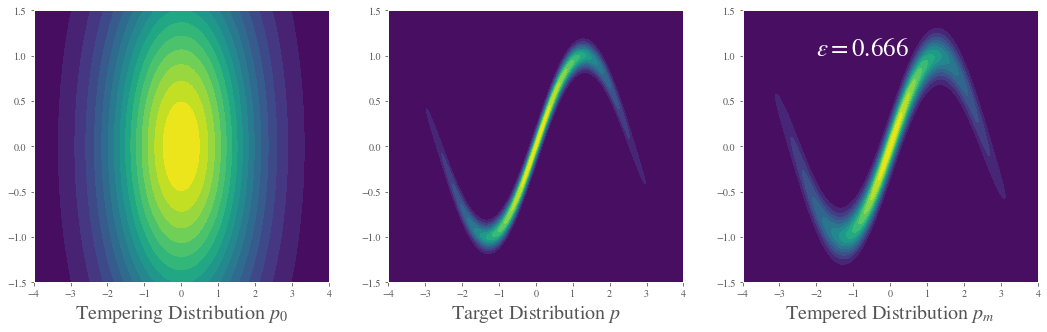

In [19]:
nnn = 5000

with torch.no_grad():
    zgrid = tempering_dist.log_prob(xyinput_sinusoidal).exp().reshape(n_steps, n_steps)
    bzgrid = sinusoidal2D.log_prob(xyinput_sinusoidal).exp().reshape(n_steps, n_steps)
    tempgrid = (sinusoidal2D.log_prob(xyinput_sinusoidal) * (1 - EPS[nnn]) + EPS[nnn] * tempering_dist.log_prob(xyinput_sinusoidal)).exp().reshape(n_steps, n_steps)

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18,5)

axes[0].contourf(xgrid_sinusoidal.numpy(), ygrid_sinusoidal.numpy(), zgrid.numpy(), levels=15)
axes[1].contourf(xgrid_sinusoidal.numpy(), ygrid_sinusoidal.numpy(), bzgrid.numpy(), levels=15)
axes[2].contourf(xgrid_sinusoidal.numpy(), ygrid_sinusoidal.numpy(), tempgrid.numpy(), levels=15)

axes[0].set_xlabel('Tempering Distribution $p_0$', fontsize=20)
axes[1].set_xlabel('Target Distribution $p$', fontsize=20)
axes[2].set_xlabel('Tempered Distribution $p_m$', fontsize=20)
axes[2].text(-2,1,'$\epsilon=$' + str(float(EPS[nnn]))[0:5], fontsize=25, color='white')

plt.show()

Loss:  tensor(0.9365, grad_fn=<LogBackward0>)  i:  0


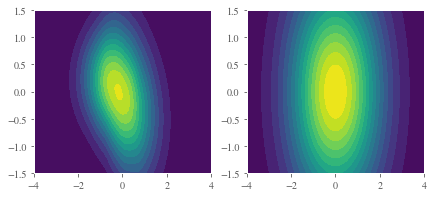

Loss:  tensor(4.0576, grad_fn=<LogBackward0>)  i:  2000


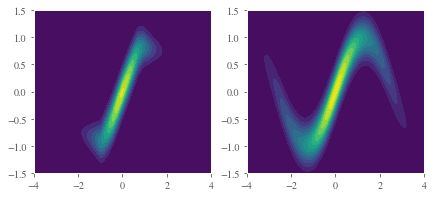

Loss:  tensor(3.9053, grad_fn=<LogBackward0>)  i:  4000


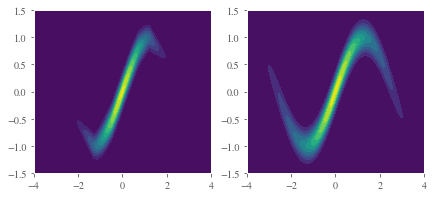

Loss:  tensor(3.5381, grad_fn=<LogBackward0>)  i:  6000


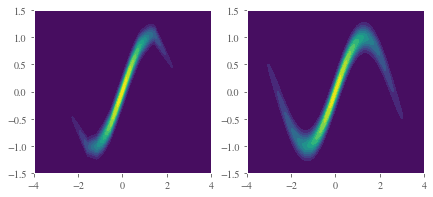

Loss:  tensor(3.1547, grad_fn=<LogBackward0>)  i:  8000


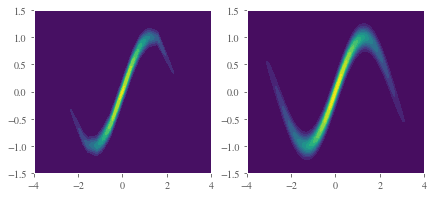

Loss:  tensor(3.3596, grad_fn=<LogBackward0>)  i:  10000


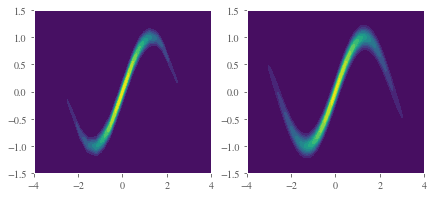

Loss:  tensor(2.5299, grad_fn=<LogBackward0>)  i:  12000


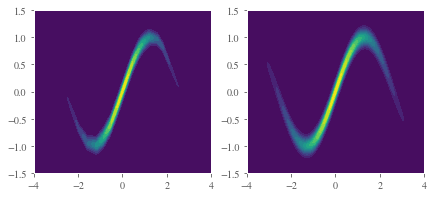

Loss:  tensor(1.5209, grad_fn=<LogBackward0>)  i:  14000


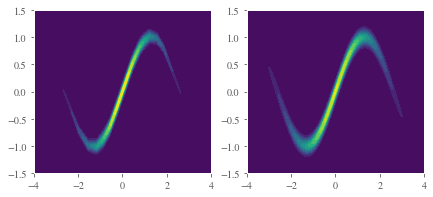

Loss:  tensor(1.1852, grad_fn=<LogBackward0>)  i:  16000


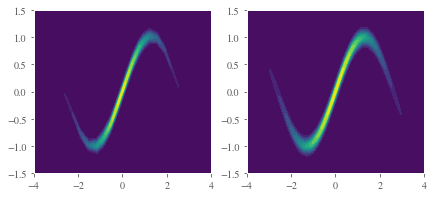

Loss:  tensor(1.7606, grad_fn=<LogBackward0>)  i:  18000


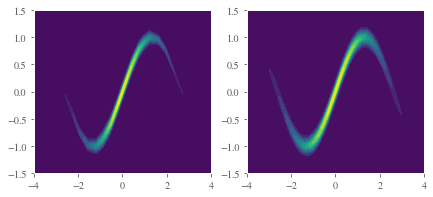

In [20]:
rcParams['figure.figsize'] = 7,3

batch = 100
optimizer = torch.optim.Adam(iaf_gfksd_sinusoidal.parameters(), lr=1e-3)

def get_score(x, dist):
    log_probs = dist.log_prob(x)
    grads = grad(log_probs.sum(), x, create_graph=True)[0]
    return grads

TARGET = sinusoidal2D
TARGET_SCORE = sinusoidal2D.score
CLAMP_P = -25
EPS = torch.cat([torch.linspace(1, 0, 15000), torch.zeros(5000)])

for i in range(20000):
    optimizer.zero_grad()

    iaf_gfksd_sinusoidal_.load_state_dict(iaf_gfksd_sinusoidal.state_dict())
    score_iaf_gfksd_sinusoidal_ = lambda x: get_score(x, transform_iaf_gfksd_sinusoidal_)

    base_dist_sample = transform_iaf_gfksd_sinusoidal.base_dist.sample(torch.Size([batch, ]))
    sample = transform_iaf_gfksd_sinusoidal.transforms[0](base_dist_sample)


    target_temp_log_prob = (TARGET.log_prob(sample) * (1 - EPS[i]) + EPS[i] * tempering_dist.log_prob(sample))

    loss =  gf_KSD.eval(sample, target_temp_log_prob, transform_iaf_gfksd_sinusoidal_.log_prob, score_iaf_gfksd_sinusoidal_, preconditioner=torch.Tensor([40]), clamp_p=CLAMP_P,  V_statistic=True).log()

    if i % 2000 == 0:
        print("Loss: ", loss, " i: ", i)
        fig, axes = plt.subplots(1, 2)

        with torch.no_grad():
            zgrid = transform_iaf_gfksd_sinusoidal.log_prob(xyinput_sinusoidal).exp().reshape(n_steps, n_steps)
            tempgrid = (TARGET.log_prob(xyinput_sinusoidal) * (1 - EPS[i]) + EPS[i] * tempering_dist.log_prob(xyinput_sinusoidal)).exp().reshape(n_steps, n_steps)

        axes[0].contourf(xgrid_sinusoidal.numpy(), ygrid_sinusoidal.numpy(), zgrid.numpy(), levels=15)
        axes[1].contourf(xgrid_sinusoidal.numpy(), ygrid_sinusoidal.numpy(), tempgrid.numpy(), levels=15)
        plt.show()

    if i == 0:
        iaf_gfksd_sinusoidal_0.load_state_dict(iaf_gfksd_sinusoidal.state_dict())
    if i == 2000:
        iaf_gfksd_sinusoidal_3000.load_state_dict(iaf_gfksd_sinusoidal.state_dict())
    if i == 10000:
        iaf_gfksd_sinusoidal_15000.load_state_dict(iaf_gfksd_sinusoidal.state_dict())

    loss.backward()
    clip_grad_norm_(iaf_gfksd_sinusoidal.parameters(), max_norm=30, norm_type=2)
    optimizer.step()


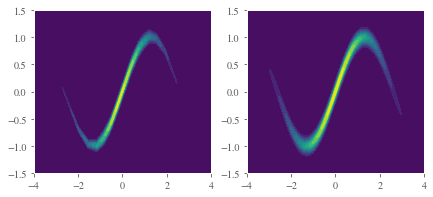

In [21]:
fig, axes = plt.subplots(1, 2)

with torch.no_grad():
    zgrid = transform_iaf_gfksd_sinusoidal.log_prob(xyinput_sinusoidal).exp().reshape(n_steps, n_steps)
    tempgrid = (TARGET.log_prob(xyinput_sinusoidal) * (1 - EPS[i]) + EPS[i] * tempering_dist.log_prob(xyinput_sinusoidal)).exp().reshape(n_steps, n_steps)

axes[0].contourf(xgrid_sinusoidal.numpy(), ygrid_sinusoidal.numpy(), zgrid.numpy(), levels=15)
axes[1].contourf(xgrid_sinusoidal.numpy(), ygrid_sinusoidal.numpy(), tempgrid.numpy(), levels=15)
plt.show()

## Plot Output

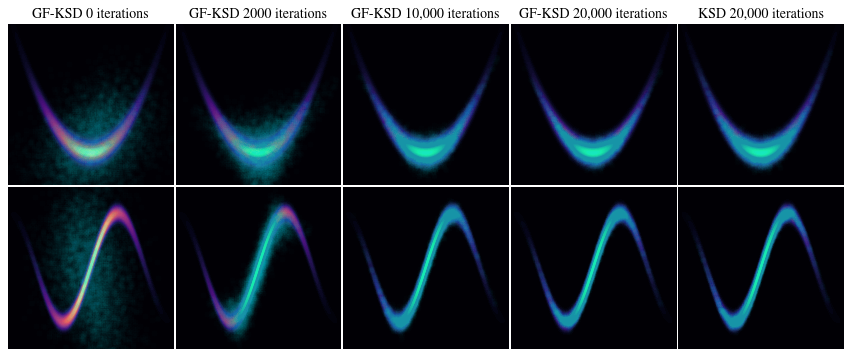

In [27]:
fig, axes = plt.subplots(nrows=2,ncols=5)
fig.set_size_inches(15, 15/5 * 2)

ALPHA = 0.01

with torch.no_grad():
    bzgrid = banana2D.log_prob(xyinput_banana).exp().reshape(n_steps, n_steps)
    szgrid = sinusoidal2D.log_prob(xyinput_sinusoidal).exp().reshape(n_steps, n_steps)

titles = ['GF-KSD 0 iterations', 'GF-KSD 2000 iterations', 'GF-KSD 10,000 iterations', 'GF-KSD 20,000 iterations', 'KSD 20,000 iterations']

for i in range(5):
    axes[0][i].contourf(xgrid_banana.numpy(), ygrid_banana.numpy(), bzgrid.numpy(), levels=80, cmap='magma', zorder=1)
    axes[0][i].set_xlim(limx)
    axes[0][i].set_ylim([-1,4])
    axes[0][i].set_title(titles[i], fontsize = 14, fontweight=100, color='black')

    axes[1][i].contourf(xgrid_sinusoidal.numpy(), ygrid_sinusoidal.numpy(), szgrid.numpy(), levels=80, cmap='magma', zorder=1)
    axes[1][i].set_xlim([-4,4])
    axes[1][i].set_ylim([-1.5,1.5])

    for j in range(2):
        axes[j][i].xaxis.set_ticks_position('none') 
        axes[j][i].set_xticklabels([])
        axes[j][i].yaxis.set_ticks_position('none') 
        axes[j][i].set_yticklabels([])
        axes[j][i].set_rasterization_zorder(3)

base_dist_sample = base_dist.sample((8000,))

gfksd_banana_0_sample = transform_iaf_gfksd_banana_0.transforms[0](base_dist_sample).detach()
gfksd_banana_3000_sample = transform_iaf_gfksd_banana_3000.transforms[0](base_dist_sample).detach()
gfksd_banana_15000_sample = transform_iaf_gfksd_banana_15000.transforms[0](base_dist_sample).detach()
gfksd_banana_30000_sample = transform_iaf_gfksd_banana.transforms[0](base_dist_sample).detach()
ksd_banana_30000_sample = transform_iaf_ksd_banana.transforms[0](base_dist_sample).detach()

axes[0][0].scatter(gfksd_banana_0_sample.T[0], gfksd_banana_0_sample.T[1], color='#17e9fc', alpha=ALPHA, zorder=2)
axes[0][1].scatter(gfksd_banana_3000_sample.T[0], gfksd_banana_3000_sample.T[1], color='#17e9fc', alpha=ALPHA, zorder=2)
axes[0][2].scatter(gfksd_banana_15000_sample.T[0], gfksd_banana_15000_sample.T[1], color='#17e9fc', alpha=ALPHA, zorder=2)
axes[0][3].scatter(gfksd_banana_30000_sample.T[0], gfksd_banana_30000_sample.T[1], color='#17e9fc', alpha=ALPHA, zorder=2)
axes[0][4].scatter(ksd_banana_30000_sample.T[0], ksd_banana_30000_sample.T[1], color='#17e9fc', alpha=ALPHA, zorder=2)

gfksd_sinusoidal_0_sample = transform_iaf_gfksd_sinusoidal_0.transforms[0](base_dist_sample).detach()
gfksd_sinusoidal_3000_sample = transform_iaf_gfksd_sinusoidal_3000.transforms[0](base_dist_sample).detach()
gfksd_sinusoidal_15000_sample = transform_iaf_gfksd_sinusoidal_15000.transforms[0](base_dist_sample).detach()
gfksd_sinusoidal_30000_sample = transform_iaf_gfksd_sinusoidal.transforms[0](base_dist_sample).detach()
ksd_sinusoidal_30000_sample = transform_iaf_ksd_sinusoidal.transforms[0](base_dist_sample).detach()

axes[1][0].scatter(gfksd_sinusoidal_0_sample.T[0], gfksd_sinusoidal_0_sample.T[1], color='#17e9fc', alpha=ALPHA, zorder=2)
axes[1][1].scatter(gfksd_sinusoidal_3000_sample.T[0], gfksd_sinusoidal_3000_sample.T[1], color='#17e9fc', alpha=ALPHA, zorder=2)
axes[1][2].scatter(gfksd_sinusoidal_15000_sample.T[0], gfksd_sinusoidal_15000_sample.T[1], color='#17e9fc', alpha=ALPHA, zorder=2)
axes[1][3].scatter(gfksd_sinusoidal_30000_sample.T[0], gfksd_sinusoidal_30000_sample.T[1], color='#17e9fc', alpha=ALPHA, zorder=2)
axes[1][4].scatter(ksd_sinusoidal_30000_sample.T[0], ksd_sinusoidal_30000_sample.T[1], color='#17e9fc', alpha=ALPHA, zorder=2)

fig.subplots_adjust(wspace=0.005, hspace=0.005)
# fig.savefig("fig_4.pdf", bbox_inches = "tight", dpi=100)

## Plotting the tempering sequence

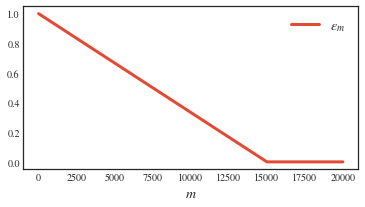

In [38]:
rcParams['figure.figsize'] = 6,3

style.use("seaborn-white")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

plt.plot(EPS, label='$\epsilon_m$', linewidth=3)
plt.xlabel('$m$', fontsize=14)
plt.legend(fontsize=14)
plt.savefig("tempering_sequence.pdf", bbox_inches = "tight", dpi=100)

## Plotting GF-KSD Variational Inference at Different Iterations